In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras import backend as K
from keras.layers import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation

In [ ]:
train_dir = "/content/drive/MyDrive/dogs_data/train"
train_images = [os.path.join(train_dir, image) for image in os.listdir(train_dir)]
print(len(train_images))
val_dir = "/content/drive/MyDrive/dogs_data/val"
val_images = [os.path.join(val_dir, image) for image in os.listdir(val_dir)]
print(len(val_images))
test_dir = "/content/drive/MyDrive/dogs_data/test"
test_images = [os.path.join(test_dir, image) for image in os.listdir(test_dir)]
print(len(test_images))

810
101
101


In [ ]:
# preprocess
image_size = 32

def preprocess(image):
    # Read and decode the image
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)

    # if augment:
    #     # Data Augmentation
    #     # Randomly flip horizontally
    #     image = tf.image.random_flip_left_right(image)

    #     angle = tf.random.uniform([], -20, 20, dtype=tf.float32)
    #     image = tfa.image.rotate(image, angle)

    #     # Randomly adjust brightness
    #     image = tf.image.random_brightness(image, max_delta=0.2)
    #     # You can change the max_delta value to control the range of brightness adjustment.

    #     # Randomly zoom in or out (scale between 0.9 and 1.1)
    #     scale = tf.random.uniform([], 0.9, 1.1, dtype=tf.float32)
    #     new_height = tf.cast(image_size * scale, dtype=tf.int32)
    #     new_width = tf.cast(image_size * scale, dtype=tf.int32)
    #     image = tf.image.resize(image, (new_height, new_width))

    #     # Randomly shear the image
    #     # shear = tf.random.uniform([], -0.2, 0.2, dtype=tf.float32)
    #     # image = tf.keras.preprocessing.image.apply_affine_transform(image, shear=shear)


    # Cast and resize the image
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape=(image_size, image_size, 3,))
    return image


In [ ]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((train_images))
# training_dataset = training_dataset.map(lambda x: preprocess(x, augment=False))
training_dataset = training_dataset.map(preprocess)

training_dataset = training_dataset.shuffle(1000).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images))
val_dataset = val_dataset.map(preprocess)
val_dataset = val_dataset.shuffle(1000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images))
test_dataset = test_dataset.map(preprocess)
test_dataset = test_dataset.shuffle(1000).batch(batch_size)

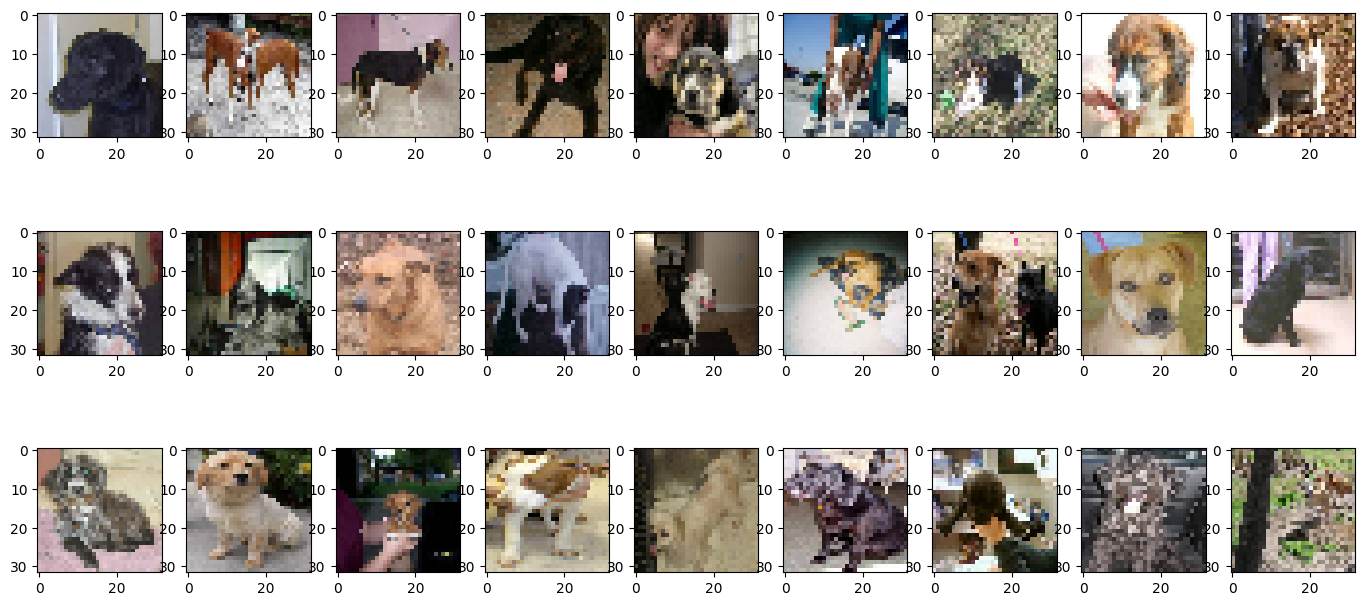

In [ ]:
# visualize some of them
fig, axes = plt.subplots(3,9, figsize = (17,8))
sample = training_dataset.unbatch().take(27)
sample = [image for image in sample]

idx = 0
for row in range(3):
    for column in range(9):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [ ]:
latent_dim = 64
encoder_input = Input(shape = (32,32,3))

x = Conv2D(16, kernel_size=3, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [32,64,128,256]
for i in filter_size:
    x = Conv2D(i, kernel_size=3, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(512, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
# encoder.summary()

In [ ]:
# build the decoder
decoder = Sequential()
decoder.add(Dense(512, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(1024, activation = selu))
decoder.add(Reshape((2,2,256)))

decoder.add(Conv2DTranspose(128, (3,3), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (3,3), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (3,3), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(16, (3,3), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (3,3), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

# decoder.summary()

In [ ]:
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [ ]:
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
# model.summary()

In [ ]:
checkpoint_path = '/content/drive/MyDrive/200e_vae_checkpoint.h5'
parameter_path = '/content/drive/MyDrive/200e_vae_checkpoint.txt'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch')

train_losses = []
val_losses = []
current_epoch = 0

In [ ]:
if os.path.exists(checkpoint_path) and os.path.exists(parameter_path):
    model = tf.keras.models.load_model(checkpoint_path)

    with open(parameter_path, 'r') as file:
        lines = file.readlines()
        current_epoch = int(lines[0].split(': ')[1])
        train_losses = [float(loss)  for loss in lines[1].split(': [')[1].strip(']\n').split(', ')]
        val_losses = [float(loss) for loss in lines[2].split(': [')[1].strip(']\n').split(', ')]

In [ ]:
random_vector = tf.random.normal(shape = (25, latent_dim,))

optimizer = Adam(0.0001,0.5)
epochs = 300

for epoch in range(current_epoch +1, epochs + 1):
    s_time = time.time()
    t_loss = 0.0
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            mse_loss = reconstruction_loss(y_true, y_pred)

            kl = sum(model.losses)

            train_loss = 0.01 * kl + mse_loss
            t_loss += train_loss.numpy()

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_losses.append(t_loss)
    v_loss = 0.0
    for step, validation_batch in enumerate(val_dataset):
        reconstructed = model(validation_batch)
        y_true = tf.reshape(validation_batch, shape=[-1])
        y_pred = tf.reshape(reconstructed, shape=[-1])

        mse_loss = reconstruction_loss(y_true, y_pred)

        kl = sum(model.losses)

        validation_loss = 0.01 * kl + mse_loss
        v_loss += validation_loss.numpy()

    v_loss = (v_loss /len(val_dataset)) * len(training_dataset)
    val_losses.append(v_loss)
    current_epoch = epoch

    model.save(checkpoint_path)

    with open(parameter_path, 'w') as file:
        file.write(f'Epoch: {current_epoch}\n')
        file.write(f'Train_losses: {train_losses}\n')
        file.write(f'Val_losses: {val_losses}\n')

    print("Epoch: %s - Train_loss: %.4f - Validation_loss: %.4f - Time: %.4f" % (epoch,t_loss,v_loss,time.time()-s_time))


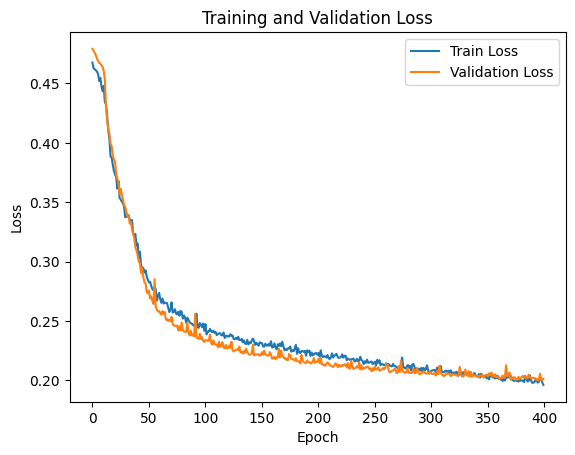

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

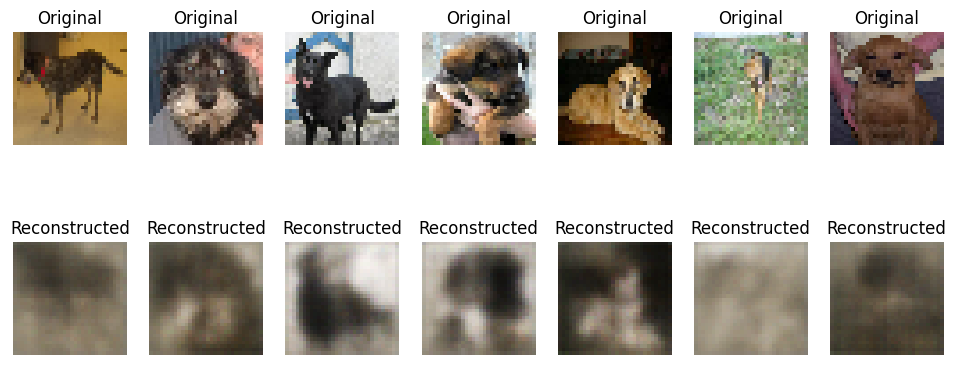

In [ ]:
def display_original_and_reconstructed_images(original, reconstructed):
    plt.figure(figsize=(12, 5))
    num_images = 7

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].numpy(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].numpy(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

original_images = []
reconstructed_images = []

for test_batch in training_dataset:
    reconstructed_batch = model(test_batch)
    original_images.append(test_batch)
    reconstructed_images.append(reconstructed_batch)

# Combine the original and reconstructed images for visualization
original_images = tf.concat(original_images, axis=0)
reconstructed_images = tf.concat(reconstructed_images, axis=0)

# Display the original and reconstructed images
display_original_and_reconstructed_images(original_images, reconstructed_images)
